# Imports

In [1]:
import pandas as pd 
import numpy as np
import requests
import io
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import drive, files
import os
import json
import random

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


# Helper Functions

In [3]:
logpath = 'drive/My Drive/mmath_cs/CHI_2020/Typealike/study_2/logs/'
logfns = os.listdir(logpath)

# these are columns that define a single trial
columns = ['Participant',            # participant id (P01, P02, ...)
           'TempBlock',
           'Block',                  # upto 3
           'Sequence',               # upto 360
           'Trial',                  # upto 720
           'Target_Type',              # what condition this particpant did (typing, pointing, gesture)
           'Target_Name',                  # whats the specific label of this target
           'Start_Time',
           'End_Time',
           'First_Reaction_Time',
           'Mode_In_Time',  #time in ms
           'Mode_Out_Time',
           'Execution_Time', # mode_in_time + mode_out_time
           'Completion_Time', # End_Time + Start_Time
           'Reference_Action_Count',
           'Incorrect_Action_Count',
           'Error',
           'IV_Surface',
           'IV_Orientation',
           'IV_Form',
           'IV_Hand',
           'Previous_Reference_Task',
           'Next_Reference_Task'
            ]

# time format in the example log is like 2018/07/10-16:41:54.4902
# see https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior
# time_format = '%Y/%m/%d-%H:%M:%S.%f'
time_format = '%Y-%m-%d %H:%M:%S.%f'



# Utilities for typical data analysis in ipython notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math
import sys
import subprocess

def remove_outliers(d, col, aggregateby, threshold = 3, verbose = False):
    """Remove outlying data points from datatable.

    d -- pandas DataFrame
    col -- column in d (must be numberic)
    aggregateby -- list of column names to aggregate col values by
    threshold -- number of standard deviations to consider an outlier (default 3)
    verbose -- print summary of col values before and after removal (defaul False)
    returns a new datatable without outliers
    """

    df = d.copy()
    # create columns for mean and stddev by aggregation
    df['TEMP_Mean'] = df.groupby(aggregateby)[col].transform('mean')
    df['TEMP_Std'] = df.groupby(aggregateby)[col].transform('std')

    # filter when more than thresh stddev away from mean
    df = df[(df[col] < df['TEMP_Mean'] + (threshold * df['TEMP_Std']))]

    # drop the temporary columns
    del(df['TEMP_Mean'])
    del(df['TEMP_Std'])

    if verbose:
        n = len(d)
        m = n - len(df)
        print('{} ({}%) outliers removed.'.format(m,m/float(n)))
        print('before')
        print(d.groupby(aggregateby)[col].agg([np.mean, np.std, np.max, len]))
        print('after')
        print(df.groupby(aggregateby)[col].agg([np.mean, np.std, np.max, len]))
    return df

def run_r(d, script, fn = '__temp__', verbose = False):
    """Runs R script file against data in DataFrame
    d -- DataFrame to save as file for R script
    fn -- filename to use for data csv and R script file
    """
    if verbose:
        print(script)

    # write data file
    d.to_csv(fn + '.csv', index = False)

    # write it out
    with open(fn + '.R', 'w') as f:
         f.write(script)

    # call it
    try:
        output = subprocess.check_output(['RScript ' + fn + '.R'], 
                                         stderr = subprocess.STDOUT, 
                                         shell = True, 
                                         universal_newlines = True)

    except subprocess.CalledProcessError as exc:
        print("FAIL {} {}\n{}".format(fn + '.R', exc.returncode, exc.output))
        return False

    else:
        return output

def posthoc(d, dv, factor1, factor1levels, factor2, showScript = True):
    """Runs R post hoc tests. Note p-values are adjusted separately for each
    call to pairwise.t.test. Would be better to adjust across all comparisons,
    but I have not idea how to do that in R (could be done manually). 
       
    d -- pandas DataFrame
    dv -- dependent variable, like 'Time' or 'ErrorRate'
    factor1 -- the factor you want to compare individual levels, e.g. 'Technique'
    factor1levels -- list of levels of that factor, e.g. ['Mouse', 'Pen', 'Touch']
    factor2 -- the factor to compare to
    """

    fn = '__temp__'

    script = """

        ## must be installed
        library(ez)

        df = read.csv("{datafn}")

        # force categorical
        df${factor1} = as.factor(df${factor1})
        df${factor2} = as.factor(df${factor2})

        """.format(datafn = fn + '.csv', 
                   factor1 = factor1, 
                   factor2 = factor2)

    for level in factor1levels:

        script += """

        cat('\n')
        print('{level}')
        pairwise.t.test(df${dv}[df${factor1} == '{level}'], 
                                df${factor2}[df${factor1} == '{level}'], 
                                p.adj="holm", 
                                paired=T)

        """.format(dv = dv, 
                   factor1 = factor1,
                   level = level,
                   factor2 = factor2
                   )

    output = run_r(d, script, fn)

    # Would be neat to parse the data in Python and format results for paper
    # or do additional manipulation of data (like manual adj of p-value for 
    # multiple pairwise comparisons)

    # Instead, we just dump it all out
    print(output)

def anova(d, dv, wid, within, showScript = True):
    """Runs R ezAnova repeated measures and post hoc test if one within factor.

    d -- pandas DataFrame
    dv -- dependent variable, like 'Time' or 'ErrorRate'
    wid -- within subject id, your 'Participant' column (P1, P2, ...)
    within -- the within factor(s) you wish to analyze, like 'Technique' or 'Block'
              use a list to pass multiple factors for interaction testing, 
              like ['Technique', 'Time']
    """
    fn = '__temp__'

    # make factors consistent
    if type(within) is not list:
        within = [ within ]

    num_factors = len(within)

    if num_factors > 1:
        within_factors = '.({})'.format(','.join(within))
    else:
        within_factors = within[0]

    within_force_categorical = ''
    for w in within:
        within_force_categorical += '    df${f} = as.factor(df${f})\n'.format(f = w)

    # make script
    script = '''

    ## must be installed
    library(ez)

    df = read.csv("{datafn}")

    # force categorical
    df${wid} = as.factor(df${wid})

{within_force_categorical}

    # run anoval
    ezANOVA(data = df,
                dv = {dv},
                wid = {wid},
                within = {within_factors})

    '''.format(datafn = fn + '.csv', dv = dv, wid = wid, within_factors = within_factors,
              within_force_categorical = within_force_categorical)
    
    # add post hoc tests for main effects (one within factor)
    if num_factors == 1:
        script += '''
        pairwise.t.test(df${dv}, df${within_factors}, p.adj="holm", paired=T)
        '''.format(dv = dv, within_factors = within_factors)
    else:
        print('NOTE: post hoc tests must be conducted manually for multiple factors\n')

    output = run_r(d, script, fn)

    # Would be neat to parse the data in Python and format results for paper
    # or do additional manipulation of data (like manual adj of p-value for 
    # multiple pairwise comparisons)

    # Instead, we just dump it all out
    print(output)


In [4]:
# helper functions

# https://stackoverflow.com/questions/17060039/split-string-at-nth-occurrence-of-a-given-character
def splitn(string, spliton, n):
    """split 'string' on nth occurence of 'spliton'
    """
    groups = string.split(spliton)
    return spliton.join(groups[:n]), spliton.join(groups[n:])


def ms_delta(t):
    """convert timedelta t to milliseconds
    """
    return round(t.seconds * 1000 + t.microseconds / 1000)

In [5]:
logpath

'drive/My Drive/mmath_cs/CHI_2020/Typealike/study_2/logs/'

## Create CSV from log files based on the above format

In [6]:
# data = open(logpath+'../mode_switching.csv', 'w')
# data.write(','.join(columns) + '\n')

for logfn in logfns:

#     print(logfn)
    filename = logfn.replace(".txt",".csv")
    data = open(logpath+'../csv/'+filename, 'w')
    data.write(','.join(columns) + '\n')
    
    modeSwitch=False
    currentTaskFirstAttempt=0;
    previousTaskEndTime=0;
    nextTaskStart=False;
    prev_task=""
    
    log = open(logpath + logfn, 'r')
    
#     initalize a dictionary of values we'll write to the datafile
    d = {e:0 for e in columns}
    
    # initalize temporary values
    trial_start_time = 0

    # we'll go through line-by-line
    line_num = 0
    trial = 0
    trial_started = False
    first_reaction_recorded = False
    reference_action_count = 0
    incorrect_action_count = 0
    keys_list = []
    for row in log:
#         print(row)
        if row[0] == '#':             
            continue
        line_num += 1
        # split the line
        row_list = row.strip().split(',')
#         if row_list[1] == :
#           pass
#         if row_list[2]
        if trial_started:
          
          if row_list[1] == 'I':
            if row_list[2] == "posture" and d['Target_Name'] != row_list[3]:
              if row_list[3] not in ["typing", "no_posture"]:
                incorrect_action_count +=1
              else:
                reference_action_count +=1
                
            if not first_reaction_recorded and row_list[2] == 'keyboard':
              first_reaction_time = row_list[0]
              first_reaction_recorded = True
            if d['Target_Type'] == "shortcut":
              if row_list[3] == "keypressed":
                keys_list.append(row_list[4])
              elif row_list[3] == "mousepressed":
                keys_list.append("mousepressed")
#                 incorrect_action_count +=1
    
        if row_list[1] == 'E':
          row_split_list = splitn(row, ',', 3)
  #         experiment_block = (row_list[1], row_list[2])
          row_inner_dict = {}
          try:
              # parse the json event data
  #                 print("PARSIG JSON")
  #                 print(r[1])
#               print(row_split_list)
              row_inner_dict = json.loads(row_split_list[1])
          except Exception as e:
              print('error parsing json event data on row{}: {}\n{}'.format(line_num, row_list[3], e))

          if row_list[2] == "experiment":
            d['Participant'] = row_inner_dict['participantid']

          if row_list[2] == "trial":
#             print(row)

            if row_inner_dict["type"] == "start":
              trial_started = True
              first_reaction_recorded = False
              d['Start_Time'] = row_list[0]
  #             d['Participant'] = row_inner_dict['participantid']
              d['Target_Type'] = row_inner_dict["targetType"]
              d['Target_Name'] = row_inner_dict["label"]
              d['Block'] = row_inner_dict["blockNum"]
              d['Sequence'] = row_inner_dict["sequenceNum"]
              d['Trial'] = trial
#               if row_inner_dict["type"] == "posture":
#               if row_inner_dict["targetType"] == "posture":
                
  
              trial+=1
            elif row_inner_dict["type"] == "end":
              trial_started = False
              d['End_Time'] = row_list[0]
              d['First_Reaction_Time'] = first_reaction_time if d['Target_Type'] == 'word' else row_list[0] # ["shortcut", "posture", "click"]
#               d['Mode_In_Time'] = int(d['First_Reaction_Time']) - int(d['Start_Time'])
              d['Reference_Action_Count'] = reference_action_count
              d['Incorrect_Action_Count'] = incorrect_action_count
              d['Error'] = False if row_inner_dict["action"] == "hit" else True
              if d["Target_Type"] == "shortcut" and len(keys_list) > 1:
#                 if :
                d['Incorrect_Action_Count'] = 1

              reference_action_count = 0
              incorrect_action_count = 0
              keys_list = []
  

              # save to log
              datarow = [d[k] for k in columns]
              datarow_csv = ','.join(str(i) for i in datarow)
    #                     print(datarow_csv)
              data.write(datarow_csv + '\n')
            
    data.close()
    print(filename)

participant_31_experiment_2019-08-29-18-49-40.csv
participant_50_experiment_2019-09-10-14-21-34.csv
participant_49_experiment_2019-09-06-20-00-11.csv
participant_48_experiment_2019-09-06-18-51-31.csv
participant_47_experiment_2019-09-06-16-47-27.csv
participant_45_experiment_2019-09-05-18-50-20.csv
participant_44_experiment_2019-09-05-17-25-07.csv
participant_43_experiment_2019-09-05-16-01-45.csv
participant_42_experiment_2019-09-05-14-19-57.csv
participant_41_experiment_2019-09-04-19-05-57.csv
participant_40_experiment_2019-09-04-18-12-17.csv
participant_39_experiment_2019-09-04-16-12-13.csv
participant_38_experiment_2019-09-04-14-54-31.csv
participant_37_experiment_2019-09-03-23-06-46.csv
participant_36_experiment_2019-09-03-16-58-26.csv
participant_35_experiment_2019-09-03-15-57-34.csv
participant_34_experiment_2019-09-02-17-51-29.csv
participant_33_experiment_2019-09-02-15-48-35.csv
participant_32_experiment_2019-08-30-16-52-53.csv
participant_46_experiment_2019-09-05-22-37-21.csv


In [8]:
f = "/content/drive/My Drive/mmath_cs/CHI_2020/Typealike/study_2/csv/participant_45_experiment_2019-09-05-18-50-20.csv"
df = pd.read_csv(f)
# df.loc[(df["Target_Type"]=="word")&(df["Block"]==5) & (df["Sequence"]==6)]#.count()#.sort_values(by=["Block","Sequence"])#"Block","Sequence").head(36)
df.loc[(df["Target_Type"] == "shortcut")]# & (df["Incorrect_Action_Count"] > 0)]

,Participant,TempBlock,Block,Sequence,Trial,Target_Type,Target_Name,Start_Time,End_Time,First_Reaction_Time,Mode_In_Time,Mode_Out_Time,Execution_Time,Completion_Time,Reference_Action_Count,Incorrect_Action_Count,Error,IV_Surface,IV_Orientation,IV_Form,IV_Hand,Previous_Reference_Task,Next_Reference_Task
73,participant_45,0,1,0,73,shortcut,D,1567723978202,1567723980434,1567723980434,0,0,0,0,0,0,False,0,0,0,0,0,0
75,participant_45,0,1,1,75,shortcut,D,1567723982736,1567723984603,1567723984603,0,0,0,0,0,0,False,0,0,0,0,0,0
77,participant_45,0,1,2,77,shortcut,J,1567723986468,1567723988302,1567723988302,0,0,0,0,0,0,False,0,0,0,0,0,0
79,participant_45,0,1,3,79,shortcut,J,1567723990400,1567723992001,1567723992001,0,0,0,0,0,0,False,0,0,0,0,0,0
81,participant_45,0,1,4,81,shortcut,O,1567723994868,1567724000901,1567724000901,0,0,0,0,0,0,True,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,participant_45,0,9,31,711,shortcut,O,1567725293583,1567725295384,1567725295384,0,0,0,0,0,0,False,0,0,0,0,0,0
713,participant_45,0,9,32,713,shortcut,D,1567725297947,1567725299950,1567725299950,0,0,0,0,0,0,False,0,0,0,0,0,0
715,participant_45,0,9,33,715,shortcut,M,1567725301184,1567725303717,1567725303717,0,0,0,0,0,0,False,0,0,0,0,0,0
717,participant_45,0,9,34,717,shortcut,U,1567725305782,1567725307549,1567725307549,0,0,0,0,0,0,False,0,0,0,0,0,0



## Form a single big dataframe for all participants

### helper function

In [9]:
def get_mode_in_out_time(df):
  mode_in_time_list = pd.Series([])
  mode_out_time_list = pd.Series([])
  execution_time_list = pd.Series([])
  completion_time_list = pd.Series([])
  exp_block_list = pd.Series([])
  prev_ref_task_list = pd.Series([])
  next_ref_task_list = pd.Series([])
  surface_iv_list = pd.Series([])
  hand_iv_list = pd.Series([])
  form_iv_list = pd.Series([])
  orientation_iv_list = pd.Series([])

  participant_handedness={
    "participant_31":"Right",
    "participant_32":"Right",
    "participant_33":"Right",
    "participant_34":"Right",
    "participant_35":"Right",
    "participant_36":"Right",
    "participant_37":"Right",
    "participant_38":"Right",
    "participant_39":"Right",
    "participant_40":"Left",
    "participant_41":"Right",
    "participant_42":"Right",
    "participant_43":"Right",
    "participant_44":"Right",
    "participant_45":"Right",
    "participant_46":"Right",
    "participant_47":"Right",
    "participant_48":"Right",
    "participant_49":"Left",
    "participant_50":"Left",

  }
  
  for i in range(len(df)): 
    start_time = df["Start_Time"][i]
    end_time = df["End_Time"][i]
    first_reaction_time = df["First_Reaction_Time"][i]
    mode_in_time_list[i] = 0 if i == 0 else mode_out_time_list[i-1]
    #   print(i, " ", len(df))
    mode_out_time_list[i] = 0 if (i+1 == len(df) or  df["Block"][i] != df["Block"][i+1]) else (df["First_Reaction_Time"][i+1] - df["End_Time"][i])
    exp_block_list[i] = int(df["Block"][i]/2)
    execution_time_list[i] = mode_in_time_list[i] + mode_out_time_list[i]
    completion_time_list[i] = df["End_Time"][i] - df["Start_Time"][i]
    
    if i+1 != len(df):
      if df["Target_Type"][i+1] in ["posture", "shortcut"]:
        next_ref_task_list[i] = "NA"
      else:
        if df["Target_Type"][i+1] == "word":
          next_ref_task_list[i] = "word"
        elif df["Target_Type"][i+1] == "click":
          next_ref_task_list[i] = "click"
    else:
      next_ref_task_list[i] = "NA"
      
    if df["Target_Type"][i] in ["word", "click"]:
      prev_ref_task_list[i] = "NA"
      surface_iv_list[i] = "NA"
      hand_iv_list[i] = "NA"
      form_iv_list[i] = "NA"
      orientation_iv_list[i] = "NA"
    else:
      prev_ref_task_list[i] = df["Target_Type"][i-1]
      if df["Target_Type"][i] == "shortcut":
        surface_iv_list[i] = "shortcut"
        hand_iv_list[i] = "shortcut"
        form_iv_list[i] = "shortcut"
        orientation_iv_list[i] = "shortcut"
      else:
        t_n_split = df["Target_Name"][i].split('_')
        #  t_n_split[0] ##chsnge left/right
        hand_iv_list[i] = "Dominant" if t_n_split[0] == participant_handedness[df["Participant"][i]] else "Non Dominant"
        form_iv_list[i] = t_n_split[1]
        orientation_iv_list[i] = t_n_split[2]#"180" if t_n_split[2] == "0" else "0" if t_n_split[2] =="180" else "90"
        surface_iv_list[i] = t_n_split[3]
        
        
#   df_usable.insert(4, "TempBlock", exp_block_list)
#   df_usable.insert(10, "Mode_In_Time", mode_in_time_list)
#   df_usable.insert(11, "Mode_Out_Time", mode_out_time_list)
  df["TempBlock"] = exp_block_list.values
  df["Mode_In_Time"] = mode_in_time_list.values
  df["Mode_Out_Time"] = mode_out_time_list.values
  df["Execution_Time"] = execution_time_list.values
  df["Completion_Time"] = completion_time_list.values
  df["Previous_Reference_Task"] = prev_ref_task_list.values
  df["Next_Reference_Task"] = next_ref_task_list.values
  df["IV_Surface"] = surface_iv_list.values
  df["IV_Orientation"] = orientation_iv_list.values
  df["IV_Form"] = form_iv_list.values
  df["IV_Hand"] = hand_iv_list.values
  
#   df_usable = df_usable.rename(columns={"Sequence":"Sub_Sequence", "Block":"Sequence", "TempBlock": "Block"})

### now read and merge

In [10]:
f = "/content/drive/My Drive/mmath_cs/CHI_2020/Typealike/study_2/csv/participant_31_experiment_2019-08-29-18-49-40.csv"
df_all = pd.read_csv(f)
get_mode_in_out_time(df_all)
csv_Path = "/content/drive/My Drive/mmath_cs/CHI_2020/Typealike/study_2/csv/"
csv_files = os.listdir(csv_Path)

for csv in csv_files:
  df = pd.read_csv(csv_Path+csv)
  if df["Participant"][0] == "participant_31" or df["Participant"][0] == "pilot_nalin":
    continue
#   print()
  get_mode_in_out_time(df)
  df_all = df_all.append(df, ignore_index=True)
#   print(df["Participant"][0])
#   if df["Participant"][0] == "participant_44":
#     dd = df.loc[df["Reference_Action_Count"] < df["Incorrect_Action_Count"]]
#     break
  print(df["Participant"][0], df.loc[df["Reference_Action_Count"] < df["Incorrect_Action_Count"]]["Incorrect_Action_Count"].count())
# df_all.loc[(df_all["Reference_Action_Count"] < df_all["Incorrect_Action_Count"]) & (df_all["Target_Name"]=="Left_Open_180_Below")].groupby(["Participant","Block"]).first()#.groupby(["Block","Sequence"]).first()
# set(df_all.loc[(df_all["Reference_Action_Count"] < df_all["Incorrect_Action_Count"])]["Target_Name"])#) & (df_all["Target_Name"]=="Right_Close_0_Below")]
# {'Right_Close_0_Below', 'Right_Close_180_Beside', 'Right_Open_180_Below'}
# df_all.loc[(df_all["Reference_Action_Count"] < df_all["Incorrect_Action_Count"])]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify

participant_50 13
participant_49 15
participant_48 8
participant_47 13
participant_44 19
participant_45 12
participant_43 10
participant_42 13
participant_41 12
participant_40 13
participant_39 12
participant_38 11
participant_37 14
participant_36 8
participant_35 15
participant_34 18
participant_33 11
participant_32 16
participant_46 12


In [11]:
df_all.head()

,Participant,TempBlock,Block,Sequence,Trial,Target_Type,Target_Name,Start_Time,End_Time,First_Reaction_Time,Mode_In_Time,Mode_Out_Time,Execution_Time,Completion_Time,Reference_Action_Count,Incorrect_Action_Count,Error,IV_Surface,IV_Orientation,IV_Form,IV_Hand,Previous_Reference_Task,Next_Reference_Task
0,participant_31,0,0,0,0,click,click me,1567118993864,1567118995310,1567118995310,0,1335,1335,1446,0,0,False,NA,NA,NA,NA,NA,NA
1,participant_31,0,0,0,1,posture,Left_Close_0_On,1567118995331,1567118996645,1567118996645,1335,1758,3093,1314,26,4,False,On,0,Close,Non Dominant,click,word
2,participant_31,0,0,1,2,word,fully,1567118996665,1567118999400,1567118998403,1758,1775,3533,2735,0,0,False,NA,NA,NA,NA,NA,NA
3,participant_31,0,0,1,3,posture,Left_Close_0_Below,1567118999434,1567119001175,1567119001175,1775,2024,3799,1741,24,0,False,Below,0,Close,Non Dominant,word,click
4,participant_31,0,0,2,4,click,click me,1567119001198,1567119003199,1567119003199,2024,1678,3702,2001,0,0,False,NA,NA,NA,NA,NA,NA


# Analysis

## Participants

## Postures

### How many mode-errors are there for each task type



In [12]:
df_all.loc[(df_all["Reference_Action_Count"] >= df_all["Incorrect_Action_Count"])].groupby("Target_Type")["Participant"].count()

Target_Type
click       3600
posture     3455
shortcut    3489
word        3600
Name: Participant, dtype: int64

In [13]:
# df_all.loc[(df_all["Participant"] == "participant_36") & (df_all["Target_Type"]=="word")]#.groupby("Target_Type")["Participant"]
# df_all.loc[(df_all["Target_Type"]=="shortcut")]#.groupby("Target_Type")["Participant"]
# df_all.loc[(df_all["Participant"] == "participant_36") & (df_all["Target_Type"]=="shortcut")].count()

### How many task-errors are there for each task type?

In [14]:
# df_all.loc[(df_all["Error"]==True) & (df_all["Target_Type"]=="posture")]#.groupby("Target_Type").count()
# # print("Task Error")
e = df_all.loc[(df_all["Error"]==True)].groupby("Target_Type")["Participant"].count()
p_id = ("posture","shortcut","word")
[(p_id[i],e[i]) for i in range(3)]

[('posture', 6), ('shortcut', 13), ('word', 74)]

In [15]:
df_all.loc[(df_all["Error"]==True) & (df_all["Target_Type"]=="posture")]

,Participant,TempBlock,Block,Sequence,Trial,Target_Type,Target_Name,Start_Time,End_Time,First_Reaction_Time,Mode_In_Time,Mode_Out_Time,Execution_Time,Completion_Time,Reference_Action_Count,Incorrect_Action_Count,Error,IV_Surface,IV_Orientation,IV_Form,IV_Hand,Previous_Reference_Task,Next_Reference_Task
3053,participant_47,1,2,14,173,posture,Left_Open_90_Beside,1567803261888,1567803267900,1567803267900,6042,1691,7733,6012,0,0,True,Beside,90,Open,Non Dominant,word,click
10113,participant_36,0,0,16,33,posture,Left_Open_180_Below,1567544393502,1567544399511,1567544399511,6041,2294,8335,6009,0,0,True,Below,180,Open,Non Dominant,word,word
10257,participant_36,1,2,16,177,posture,Left_Open_180_Below,1567544735081,1567544741090,1567544741090,6043,1757,7800,6009,0,0,True,Below,180,Open,Non Dominant,word,word
10401,participant_36,2,4,16,321,posture,Left_Open_180_Below,1567545046692,1567545052701,1567545052701,6040,1292,7332,6009,0,0,True,Below,180,Open,Non Dominant,word,word
13031,participant_32,0,0,35,71,posture,Right_Open_180_Beside,1567198587616,1567198593625,1567198593625,6041,0,6041,6009,0,0,True,Beside,180,Open,Dominant,click,click
13175,participant_32,1,2,35,215,posture,Right_Open_180_Beside,1567198879461,1567198885471,1567198885471,6046,0,6046,6010,0,0,True,Beside,180,Open,Dominant,click,click


In [16]:
# Rename columns
# df_all = df_all.rename(columns={"Sequence":"Sub_Sequence", "Block":"Sequence", "TempBlock": "Block"})
df_all.head()

,Participant,TempBlock,Block,Sequence,Trial,Target_Type,Target_Name,Start_Time,End_Time,First_Reaction_Time,Mode_In_Time,Mode_Out_Time,Execution_Time,Completion_Time,Reference_Action_Count,Incorrect_Action_Count,Error,IV_Surface,IV_Orientation,IV_Form,IV_Hand,Previous_Reference_Task,Next_Reference_Task
0,participant_31,0,0,0,0,click,click me,1567118993864,1567118995310,1567118995310,0,1335,1335,1446,0,0,False,NA,NA,NA,NA,NA,NA
1,participant_31,0,0,0,1,posture,Left_Close_0_On,1567118995331,1567118996645,1567118996645,1335,1758,3093,1314,26,4,False,On,0,Close,Non Dominant,click,word
2,participant_31,0,0,1,2,word,fully,1567118996665,1567118999400,1567118998403,1758,1775,3533,2735,0,0,False,NA,NA,NA,NA,NA,NA
3,participant_31,0,0,1,3,posture,Left_Close_0_Below,1567118999434,1567119001175,1567119001175,1775,2024,3799,1741,24,0,False,Below,0,Close,Non Dominant,word,click
4,participant_31,0,0,2,4,click,click me,1567119001198,1567119003199,1567119003199,2024,1678,3702,2001,0,0,False,NA,NA,NA,NA,NA,NA


### Pre processing

In [17]:
# Separate erraneous trials
df_error = df_all.loc[(df_all["Reference_Action_Count"] < df_all["Incorrect_Action_Count"]) & (df_all["Error"]==True)]
df_error_filtered = df_error.loc[(df_error["Target_Type"]=="shortcut")|(df_error["Target_Type"]=="posture")]
df_error_filtered_outliers = remove_outliers(df_error_filtered, 'Completion_Time', aggregateby=['Block','Participant'], threshold=1)

# Separate error-free trials
df_error_free = df_all.loc[(df_all["Reference_Action_Count"] >= df_all["Incorrect_Action_Count"]) & (df_all["Error"]==False)]
df_error_free_filtered = df_error_free.loc[(df_error_free["Target_Type"]=="shortcut")|(df_error_free["Target_Type"]=="posture")]
df_error_free_filtered_outliers = remove_outliers(df_error_free_filtered, 'Completion_Time', aggregateby=['Block','Participant'], threshold=1)
df_error_free_filtered_outliers_2_5= df_error_free_filtered_outliers.loc[df_error_free_filtered_outliers["Block"]!=0]


In [18]:
print(df_error_free_filtered.count()[0])
print(df_error_free_filtered_outliers.count()[0])

6927
6083


In [19]:
# print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="posture") & (df_2_to_5["Reference_Task"]=="click")]["Completion_Time"].mean())
# print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="shortcut") & (df_2_to_5["Reference_Task"]=="click")]["Completion_Time"].mean())
print(df_error_free_filtered_outliers_2_5.loc[(df_error_free_filtered_outliers_2_5["Target_Type"]=="posture")]["Completion_Time"].mean())
print(df_error_free_filtered_outliers_2_5.loc[(df_error_free_filtered_outliers_2_5["Target_Type"]=="posture")]["Completion_Time"].std())
print(df_error_free_filtered_outliers_2_5.loc[(df_error_free_filtered_outliers_2_5["Target_Type"]=="shortcut")]["Completion_Time"].mean())
print(df_error_free_filtered_outliers_2_5.loc[(df_error_free_filtered_outliers_2_5["Target_Type"]=="shortcut")]["Completion_Time"].std())
# print(list(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="posture") & (df_2_to_5["Reference_Task"]=="click")]["Completion_Time"]))

# data_filtered.loc[(data_filtered["Target_Type"]=="shortcut") & (data_filtered["Reference_Task"]=="click")].groupby("Block")["Completion_Time"].mean()


1139.050963081862
244.2308226085279
1738.7931954636424
458.3144445215733


In [20]:
# Download errenous
df_error_filtered_outliers.to_csv('df_error_filtered_outliers.csv') 
files.download('df_error_filtered_outliers.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# Download error-free trials with all the blocks 1-5
#  We need it for ANOVA
df_error_free_filtered_outliers.to_csv('df_error_free_filtered_outliers_1_5.csv') 
files.download('df_error_free_filtered_outliers_1_5.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# Download error-free for only block 2-5
df_error_free_filtered_outliers_2_5.to_csv('df_error_free_filtered_outliers_2_5.csv') 
files.download('df_error_free_filtered_outliers_2_5.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
df_error_free_filtered_outliers_2_5.loc[df_error_free_filtered_outliers_2_5["IV_Hand"]=="shortcut"]

,Participant,TempBlock,Block,Sequence,Trial,Target_Type,Target_Name,Start_Time,End_Time,First_Reaction_Time,Mode_In_Time,Mode_Out_Time,Execution_Time,Completion_Time,Reference_Action_Count,Incorrect_Action_Count,Error,IV_Surface,IV_Orientation,IV_Form,IV_Hand,Previous_Reference_Task,Next_Reference_Task
77,participant_31,0,1,2,77,shortcut,down,1567119184273,1567119186772,1567119186772,2531,133,2664,2499,0,0,False,shortcut,shortcut,shortcut,shortcut,click,word
79,participant_31,0,1,3,79,shortcut,E,1567119188973,1567119191241,1567119191241,2301,100,2401,2268,0,0,False,shortcut,shortcut,shortcut,shortcut,word,word
81,participant_31,0,1,4,81,shortcut,Y,1567119193205,1567119195141,1567119195141,1966,1563,3529,1936,0,0,False,shortcut,shortcut,shortcut,shortcut,word,click
83,participant_31,0,1,5,83,shortcut,L,1567119196738,1567119198874,1567119198874,2170,130,2300,2136,0,0,False,shortcut,shortcut,shortcut,shortcut,click,word
85,participant_31,0,1,6,85,shortcut,F,1567119200908,1567119203840,1567119203840,2968,2001,4969,2932,0,0,False,shortcut,shortcut,shortcut,shortcut,word,click
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14389,participant_46,4,9,30,709,shortcut,F,1567739017140,1567739019607,1567739019607,2497,103,2600,2467,0,0,False,shortcut,shortcut,shortcut,shortcut,click,word
14391,participant_46,4,9,31,711,shortcut,A,1567739021709,1567739022940,1567739022940,1267,102,1369,1231,0,0,False,shortcut,shortcut,shortcut,shortcut,word,word
14393,participant_46,4,9,32,713,shortcut,K,1567739026042,1567739027277,1567739027277,1267,2398,3665,1235,0,0,False,shortcut,shortcut,shortcut,shortcut,word,click
14395,participant_46,4,9,33,715,shortcut,S,1567739029709,1567739031574,1567739031574,1899,103,2002,1865,0,0,False,shortcut,shortcut,shortcut,shortcut,click,word


No handles with labels found to put in legend.


(1000.0, 2000.0)

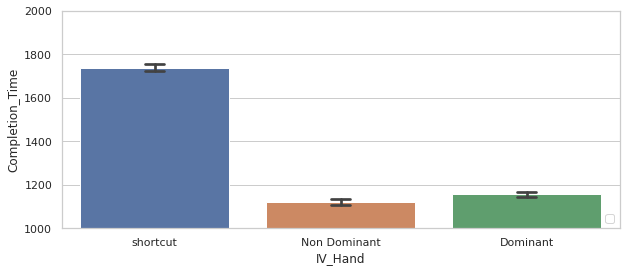

In [24]:
sns.set(style="whitegrid")
# plt.ylim(1000, 2000)

plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="Block", y="Execution_Time",hue="IV_Surface", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="IV_Hand", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1)
ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)
ax.axes.set_ylim(1000,2000)

In [25]:
df_error_free_filtered_outliers_2_5.head()

,Participant,TempBlock,Block,Sequence,Trial,Target_Type,Target_Name,Start_Time,End_Time,First_Reaction_Time,Mode_In_Time,Mode_Out_Time,Execution_Time,Completion_Time,Reference_Action_Count,Incorrect_Action_Count,Error,IV_Surface,IV_Orientation,IV_Form,IV_Hand,Previous_Reference_Task,Next_Reference_Task
77,participant_31,0,1,2,77,shortcut,down,1567119184273,1567119186772,1567119186772,2531,133,2664,2499,0,0,False,shortcut,shortcut,shortcut,shortcut,click,word
79,participant_31,0,1,3,79,shortcut,E,1567119188973,1567119191241,1567119191241,2301,100,2401,2268,0,0,False,shortcut,shortcut,shortcut,shortcut,word,word
81,participant_31,0,1,4,81,shortcut,Y,1567119193205,1567119195141,1567119195141,1966,1563,3529,1936,0,0,False,shortcut,shortcut,shortcut,shortcut,word,click
83,participant_31,0,1,5,83,shortcut,L,1567119196738,1567119198874,1567119198874,2170,130,2300,2136,0,0,False,shortcut,shortcut,shortcut,shortcut,click,word
85,participant_31,0,1,6,85,shortcut,F,1567119200908,1567119203840,1567119203840,2968,2001,4969,2932,0,0,False,shortcut,shortcut,shortcut,shortcut,word,click


In [26]:
df_error_free_filtered_outliers_2_5["IV_Orientation"] = df_error_free_filtered_outliers_2_5["IV_Orientation"].replace({"shortcut":"Shortcut"})
df_error_free_filtered_outliers_2_5["IV_Form"] = df_error_free_filtered_outliers_2_5["IV_Form"].replace({"shortcut":"Shortcut"})
df_error_free_filtered_outliers_2_5["IV_Hand"] = df_error_free_filtered_outliers_2_5["IV_Hand"].replace({"shortcut":"Shortcut"})
df_error_free_filtered_outliers_2_5["IV_Surface"] = df_error_free_filtered_outliers_2_5["IV_Surface"].replace({"shortcut":"Shortcut"})

df_error_free_filtered_outliers_2_5["Target_Type"] = df_error_free_filtered_outliers_2_5["Target_Type"].replace({"shortcut":"Shortcut", "posture":"Posture"})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

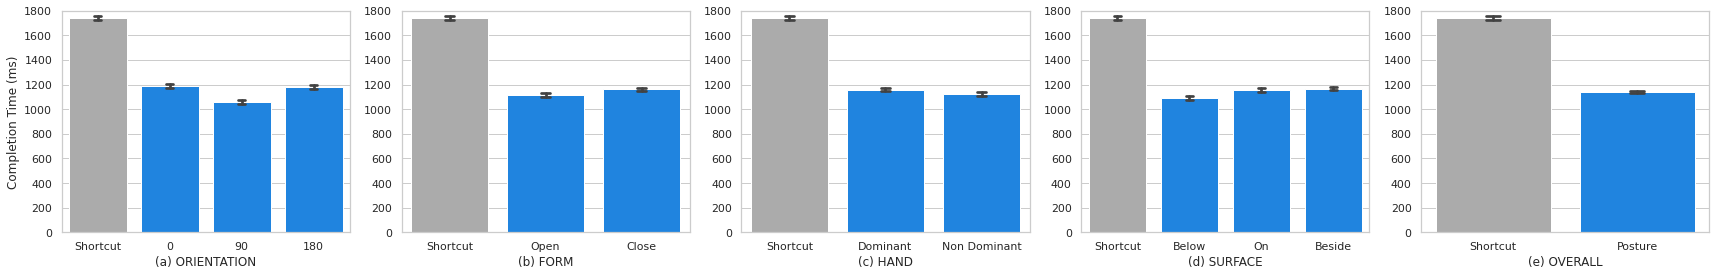

In [30]:
sns.set(style="whitegrid")

# Set up the matplotlib figure
f, axes = plt.subplots(1, 5, figsize=(24, 4))

# Create an array with the colors you want to use
colors = ["#ABABAB", "#0085FF", "#0085FF", "#0085FF"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

# Plot a simple histogram with binsize determined automatically
# sns.barplot(x="form", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[0, 0])
ax1 = sns.barplot(x="IV_Orientation", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[0], order=["Shortcut","0", "90", "180"])
ax2 = sns.barplot(x="IV_Form", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[1], order=["Shortcut","Open", "Close"])
ax3 = sns.barplot(x="IV_Hand", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[2], order=["Shortcut","Dominant", "Non Dominant"])
ax4 = sns.barplot(x="IV_Surface", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[3], order=["Shortcut","Below", "On", "Beside"])
ax5 = sns.barplot(x="Target_Type", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[4], order=["Shortcut","Posture"])
# ax1.get_legend().set_visible(False)
# ax2.get_legend().set_visible(False)
# ax3.get_legend().set_visible(False)
# ax4.get_legend().set_visible(False)
ax2.set_ylabel('') 
ax4.set_ylabel('') 
y_min = 0
y_max = 1800

ax1.axes.set_ylim(y_min,y_max)
ax2.axes.set_ylim(y_min,y_max)
# ax2.set_yticklabels([])
ax3.axes.set_ylim(y_min,y_max)
ax4.axes.set_ylim(y_min,y_max)
ax5.axes.set_ylim(y_min,y_max)
# ax4.set_yticklabels([])


ax1.set_xlabel('(a) ORIENTATION') 
ax2.set_xlabel('(b) FORM') 
ax3.set_xlabel('(c) HAND') 
ax4.set_xlabel('(d) SURFACE') 
ax5.set_xlabel('(e) OVERALL') 
ax1.set_ylabel('Completion Time (ms)') 
ax2.set_ylabel('') 
ax3.set_ylabel('') 
ax4.set_ylabel('') 
ax5.set_ylabel('') 


# sns.palplot(sns.color_palette(flatui))
# plt.setp(axes,)
plt.tight_layout()
f.savefig('study_2_task_completion.pdf', dpi=300, bbox_inches='tight')

In [ ]:
df_error_free_filtered_outliers_2_5.loc[df_error_free_filtered_outliers_2_5["Target_Type"]=="shortcut"].groupby("Block")["Mode_Out_Time"].mean()#

Series([], Name: Mode_Out_Time, dtype: int64)

In [ ]:
# df_error_free_filtered_outliers_2_5.groupby("Participant")["Mode_Out_Time"].std()
df_error_free_filtered_outliers_2_5_from_word = df_error_free_filtered_outliers_2_5.loc[(df_error_free_filtered_outliers_2_5["Previous_Reference_Task"]=="word")]
df_error_free_filtered_outliers_2_5_from_click = df_error_free_filtered_outliers_2_5.loc[(df_error_free_filtered_outliers_2_5["Previous_Reference_Task"]=="click")]
df_error_free_filtered_outliers_2_5_to_word = df_error_free_filtered_outliers_2_5.loc[(df_error_free_filtered_outliers_2_5["Next_Reference_Task"]=="word")]
df_error_free_filtered_outliers_2_5_to_click = df_error_free_filtered_outliers_2_5.loc[(df_error_free_filtered_outliers_2_5["Next_Reference_Task"]=="click")]

In [ ]:
df_error_free_filtered_outliers_2_5_to_click.count()

Participant                2720
TempBlock                  2720
Block                      2720
Sequence                   2720
Trial                      2720
Target_Type                2720
Target_Name                2720
Start_Time                 2720
End_Time                   2720
First_Reaction_Time        2720
Mode_In_Time               2720
Mode_Out_Time              2720
Execution_Time             2720
Completion_Time            2720
Reference_Action_Count     2720
Incorrect_Action_Count     2720
Error                      2720
IV_Surface                 2720
IV_Orientation             2720
IV_Form                    2720
IV_Hand                    2720
Previous_Reference_Task    2720
Next_Reference_Task        2720
dtype: int64

In [ ]:
# Download error-free
df_error_free_filtered_outliers_2_5_word.to_csv('df_error_free_filtered_outliers_2_5_word.csv') 
files.download('df_error_free_filtered_outliers_2_5_word.csv')

NameError: ignored

In [ ]:
# Download error-free
df_error_free_filtered_outliers_2_5_click.to_csv('df_error_free_filtered_outliers_2_5_click.csv') 
files.download('df_error_free_filtered_outliers_2_5_click.csv')

NameError: ignored

#### considering only the transition time "from" typing/clicking 

NameError: ignored

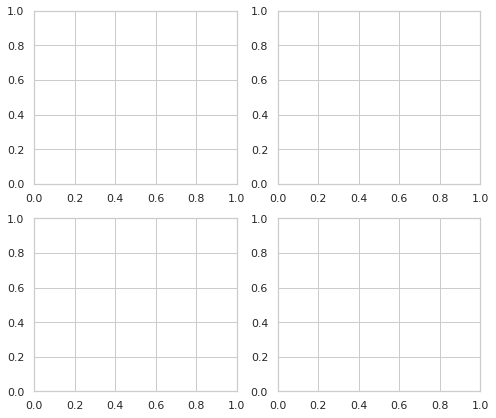

In [ ]:
# ax = sns.boxplot(x="Target_Type", y="Mode_In_Time", data=df_error_free_filtered_outliers_2_5)
# ax = sns.pointplot(x="Target_Type", y="Mode_In_Time", err_style="bars", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ci=95, dashes=True)
# ax = sns.barplot(x="Target_Type", y="Mode_In_Time", data=df_error_free_filtered_outliers_2_5_word)


sns.set(style="whitegrid")

# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(8, 7))

# Plot a simple histogram with binsize determined automatically
# sns.barplot(x="form", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[0, 0])
ax1 = sns.barplot(x="Target_Type", y="Mode_In_Time", data=df_error_free_filtered_outliers_2_5_word, capsize=0.1, ax=axes[0,0])#, order=["shortcut","0", "90", "180"])
ax2 = sns.barplot(x="Target_Type", y="Mode_In_Time", data=df_error_free_filtered_outliers_2_5_click, capsize=0.1, ax=axes[0,1])#, order=["shortcut","0", "90", "180"])
ax3 = sns.barplot(x="Target_Type", y="Mode_Out_Time", data=df_error_free_filtered_outliers_2_5_word, capsize=0.1, ax=axes[1,0])#, order=["shortcut","0", "90", "180"])
ax4 = sns.barplot(x="Target_Type", y="Mode_Out_Time", data=df_error_free_filtered_outliers_2_5_click, capsize=0.1, ax=axes[1,1])#, order=["shortcut","0", "90", "180"])

# ax1 = sns.barplot(x="IV_Orientation", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[0, 0], order=["shortcut","0", "90", "180"])
# ax2 = sns.barplot(x="IV_Form", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[0, 1], order=["shortcut","Open", "Close"])
# ax3 = sns.barplot(x="IV_Hand", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[1, 0], order=["shortcut","Dominant", "Non Dominant"])
# ax4 = sns.barplot(x="IV_Surface", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[1, 1], order=["shortcut","Below", "Beside","On"])

# ax1.get_legend().set_visible(False)
# ax2.get_legend().set_visible(False)
# ax3.get_legend().set_visible(False)
# ax4.get_legend().set_visible(False)
ax2.set_ylabel('') 
# ax4.set_ylabel('') 
y_min_a = 500
y_max_a = 4200
y_min_b = 100
y_max_b = 1500
ax1.axes.set_ylim(y_min_a,y_max_a)
ax2.axes.set_ylim(y_min_a,y_max_a)
ax3.axes.set_ylim(y_min_b,y_max_b)
ax4.axes.set_ylim(y_min_b,y_max_b)

# plt.setp(axes,)
plt.tight_layout()


#### considering transition time FROM typing/clicking TO the SAME reference task of typing/clicking

NameError: ignored

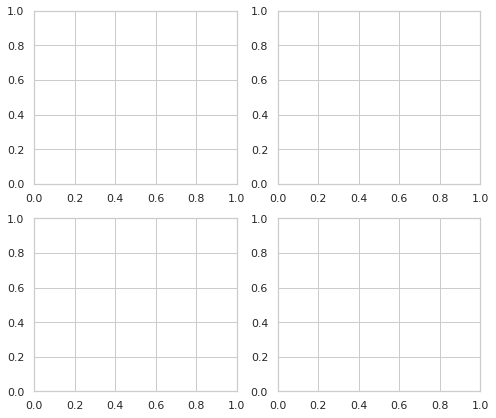

In [ ]:
# ax = sns.boxplot(x="Target_Type", y="Mode_In_Time", data=df_error_free_filtered_outliers_2_5)
# ax = sns.pointplot(x="Target_Type", y="Mode_In_Time", err_style="bars", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ci=95, dashes=True)
# ax = sns.barplot(x="Target_Type", y="Mode_In_Time", data=df_error_free_filtered_outliers_2_5_word)


sns.set(style="whitegrid")

# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(8, 7))

# Plot a simple histogram with binsize determined automatically
# sns.barplot(x="form", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[0, 0])
ax1 = sns.barplot(x="Target_Type", y="Mode_In_Time", data=df_error_free_filtered_outliers_2_5_word, capsize=0.1, ax=axes[0,0])#, order=["shortcut","0", "90", "180"])
ax2 = sns.barplot(x="Target_Type", y="Mode_In_Time", data=df_error_free_filtered_outliers_2_5_click, capsize=0.1, ax=axes[0,1])#, order=["shortcut","0", "90", "180"])
ax3 = sns.barplot(x="Target_Type", y="Mode_Out_Time", data=df_error_free_filtered_outliers_2_5_word, capsize=0.1, ax=axes[1,0])#, order=["shortcut","0", "90", "180"])
ax4 = sns.barplot(x="Target_Type", y="Mode_Out_Time", data=df_error_free_filtered_outliers_2_5_click, capsize=0.1, ax=axes[1,1])#, order=["shortcut","0", "90", "180"])

# ax1 = sns.barplot(x="IV_Orientation", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[0, 0], order=["shortcut","0", "90", "180"])
# ax2 = sns.barplot(x="IV_Form", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[0, 1], order=["shortcut","Open", "Close"])
# ax3 = sns.barplot(x="IV_Hand", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[1, 0], order=["shortcut","Dominant", "Non Dominant"])
# ax4 = sns.barplot(x="IV_Surface", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[1, 1], order=["shortcut","Below", "Beside","On"])

# ax1.get_legend().set_visible(False)
# ax2.get_legend().set_visible(False)
# ax3.get_legend().set_visible(False)
# ax4.get_legend().set_visible(False)
ax2.set_ylabel('') 
# ax4.set_ylabel('') 
y_min_a = 500
y_max_a = 4300
y_min_b = 10
y_max_b = 1400
ax1.axes.set_ylim(y_min_a,y_max_a)
ax2.axes.set_ylim(y_min_a,y_max_a)
ax3.axes.set_ylim(y_min_b,y_max_b)
ax4.axes.set_ylim(y_min_b,y_max_b)

# plt.setp(axes,)
plt.tight_layout()


#### considering transition time FROM typing/clicking TO same(or different) reference task of typing/clicking

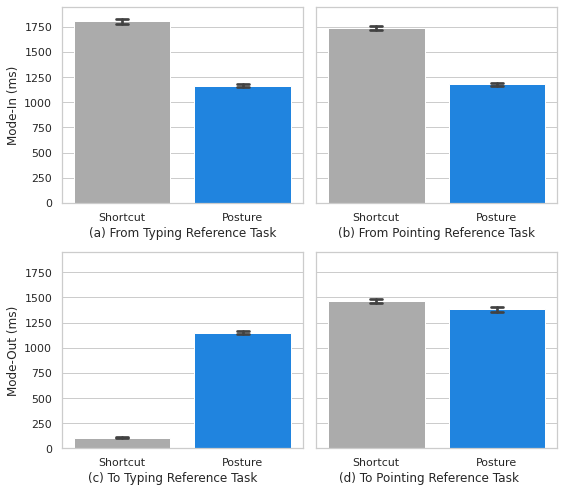

In [ ]:
# ax = sns.boxplot(x="Target_Type", y="Mode_In_Time", data=df_error_free_filtered_outliers_2_5)
# ax = sns.pointplot(x="Target_Type", y="Mode_In_Time", err_style="bars", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ci=95, dashes=True)
# ax = sns.barplot(x="Target_Type", y="Mode_In_Time", data=df_error_free_filtered_outliers_2_5_word)


sns.set(style="whitegrid")

# Create an array with the colors you want to use
colors = ["#ABABAB", "#0085FF", "#0085FF", "#0085FF"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))


# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(8, 7))

# Plot a simple histogram with binsize determined automatically
# sns.barplot(x="form", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[0, 0])
ax1 = sns.barplot(x="Target_Type", y="Mode_In_Time", data=df_error_free_filtered_outliers_2_5_from_word, capsize=0.1, ax=axes[0,0])#, order=["shortcut","0", "90", "180"])
ax2 = sns.barplot(x="Target_Type", y="Mode_In_Time", data=df_error_free_filtered_outliers_2_5_from_click, capsize=0.1, ax=axes[0,1])#, order=["shortcut","0", "90", "180"])
ax3 = sns.barplot(x="Target_Type", y="Mode_Out_Time", data=df_error_free_filtered_outliers_2_5_to_word, capsize=0.1, ax=axes[1,0])#, order=["shortcut","0", "90", "180"])
ax4 = sns.barplot(x="Target_Type", y="Mode_Out_Time", data=df_error_free_filtered_outliers_2_5_to_click, capsize=0.1, ax=axes[1,1])#, order=["shortcut","0", "90", "180"])

# ax1 = sns.barplot(x="IV_Orientation", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[0, 0], order=["shortcut","0", "90", "180"])
# ax2 = sns.barplot(x="IV_Form", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[0, 1], order=["shortcut","Open", "Close"])
# ax3 = sns.barplot(x="IV_Hand", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[1, 0], order=["shortcut","Dominant", "Non Dominant"])
# ax4 = sns.barplot(x="IV_Surface", y="Completion_Time", data=df_error_free_filtered_outliers_2_5, capsize=0.1, ax=axes[1, 1], order=["shortcut","Below", "Beside","On"])

# ax1.get_legend().set_visible(False)
# ax2.get_legend().set_visible(False)
# ax3.get_legend().set_visible(False)
# ax4.get_legend().set_visible(False)
ax2.set_ylabel('') 
ax4.set_ylabel('') 
y_min_a = 0
y_max_a = 1950
y_min_b = 0
y_max_b = 1950
ax1.axes.set_ylim(y_min_a,y_max_a)
ax2.axes.set_ylim(y_min_a,y_max_a)
ax2.set_yticklabels([])
ax3.axes.set_ylim(y_min_b,y_max_b)
ax4.axes.set_ylim(y_min_b,y_max_b)
ax4.set_yticklabels([])

ax1.set_xlabel('(a) From Typing Reference Task') 
ax2.set_xlabel('(b) From Pointing Reference Task')
ax3.set_xlabel('(c) To Typing Reference Task     ') 
ax4.set_xlabel('(d) To Pointing Reference Task    ') 

ax1.set_ylabel('Mode-In (ms)')
ax3.set_ylabel('Mode-Out (ms)')

# plt.setp(axes,)
plt.tight_layout()
f.savefig("study_2_task_transition.pdf", dpi=300, bbox_inches='tight')


### Calculate mode-in and mode-out **time**

#### Create a dataframe that does not include trials with mode-errors/task-errors.

In [ ]:
df_filtered = df_all.loc[(df_all["Reference_Action_Count"] >= df_all["Incorrect_Action_Count"]) & (df_all["Error"]==False)]
print(df_filtered.count())
data_filtered = df_filtered.loc[(df_filtered['Target_Type'] == "shortcut") | (df_filtered['Target_Type'] == "posture")]
print(data_filtered.count())
# data_filtered_word = df_filtered.loc[(df_filtered['Reference_Task'] == "word")]
# data_filtered_click = df_filtered.loc[(df_filtered['Reference_Task'] == "click")]

Participant                14053
TempBlock                  14053
Block                      14053
Sequence                   14053
Trial                      14053
Target_Type                14053
Target_Name                14053
Start_Time                 14053
End_Time                   14053
First_Reaction_Time        14053
Mode_In_Time               14053
Mode_Out_Time              14053
Execution_Time             14053
Completion_Time            14053
Reference_Action_Count     14053
Incorrect_Action_Count     14053
Error                      14053
IV_Surface                 14053
IV_Orientation             14053
IV_Form                    14053
IV_Hand                    14053
Previous_Reference_Task    14053
Next_Reference_Task        14053
dtype: int64
Participant                6927
TempBlock                  6927
Block                      6927
Sequence                   6927
Trial                      6927
Target_Type                6927
Target_Name                6927
Star

In [ ]:
data_filtered.head()

,Participant,TempBlock,Block,Sequence,Trial,Target_Type,Target_Name,Start_Time,End_Time,First_Reaction_Time,Mode_In_Time,Mode_Out_Time,Execution_Time,Completion_Time,Reference_Action_Count,Incorrect_Action_Count,Error,IV_Surface,IV_Orientation,IV_Form,IV_Hand,Previous_Reference_Task,Next_Reference_Task
1,participant_31,0,0,0,1,posture,Left_Close_0_On,1567118995331,1567118996645,1567118996645,1335,1758,3093,1314,26,4,False,On,0,Close,Non Dominant,click,word
3,participant_31,0,0,1,3,posture,Left_Close_0_Below,1567118999434,1567119001175,1567119001175,1775,2024,3799,1741,24,0,False,Below,0,Close,Non Dominant,word,click
5,participant_31,0,0,2,5,posture,Left_Close_0_Beside,1567119003230,1567119004877,1567119004877,1678,1523,3201,1647,28,0,False,Beside,0,Close,Non Dominant,click,word
7,participant_31,0,0,3,7,posture,Left_Close_90_On,1567119008531,1567119009846,1567119009846,1346,2419,3765,1315,17,8,False,On,90,Close,Non Dominant,word,word
9,participant_31,0,0,4,9,posture,Left_Close_90_Below,1567119014167,1567119015578,1567119015578,1445,1688,3133,1411,23,8,False,Below,90,Close,Non Dominant,word,click


#### Prepare data to plot

In [ ]:
data_baseline = df_all.loc[(df_all['Target_Type'] != "shortcut") & (df_all['Target_Type'] != "posture")]
# data_baseline.count()
data_baseline.loc[data_baseline["Error"]==True].count()


Participant                74
TempBlock                  74
Block                      74
Sequence                   74
Trial                      74
Target_Type                74
Target_Name                74
Start_Time                 74
End_Time                   74
First_Reaction_Time        74
Mode_In_Time               74
Mode_Out_Time              74
Execution_Time             74
Completion_Time            74
Reference_Action_Count     74
Incorrect_Action_Count     74
Error                      74
IV_Surface                 74
IV_Orientation             74
IV_Form                    74
IV_Hand                    74
Previous_Reference_Task    74
Next_Reference_Task        74
dtype: int64

### Mode_In Time (filtered vs unfiltered)

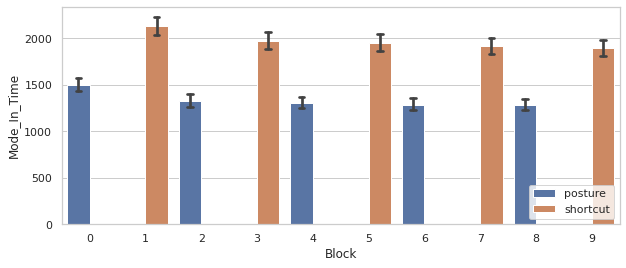

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# plt.xticks(rotation=90)
ax = sns.barplot(x="Block", y="Mode_In_Time", hue="Target_Type", data=data_filtered, capsize=0.1, ci=100)
# ax = sns.swarmplot(x="Block", y="Execution_Time",hue="Target_Type", data=data_filtered_word)
ax.legend(loc='lower right')

In [ ]:
data_filtered_word.head()

NameError: ignored

### Mode_Out Time (filtered vs unfiltered)

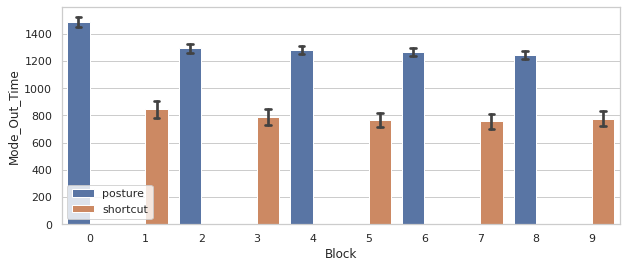

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# plt.xticks(rotation=90)
ax = sns.barplot(x="Block", y="Mode_Out_Time", hue="Target_Type", data=data_filtered, capsize=0.1)
ax.legend(loc='lower left')

### Total Execution Time (filtered vs unfiltered)
#### Total Execution Time = (mode-in + mode-out)

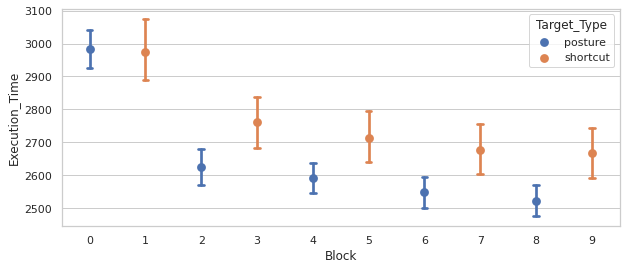

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# plt.xticks(rotation=90)
# ax = sns.barplot(x="Block", y="Execution_Time", hue="Target_Type", data=data_filtered, capsize=0.1, ci=95)
ax = sns.pointplot(x="Block", y="Execution_Time",hue="Target_Type", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
# ax = sns.swarmplot(x="Block", y="Execution_Time",hue="Target_Type", data=data_filtered)
# ax = sns.lineplot(x="Block", y="Execution_Time", hue="Target_Type", units="subject", estimator=None, lw=1, data=fmri.query("region == 'frontal'"))

# ax.legend(loc='upper right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)
# plt.xlim(0, 4)
# plt.grid('off')
# Add rectangle
# ax.add_patch(
# patches.Rectangle(
# (50, 50), # (x,y)
# 50, # width
# 50, # height
# # You can add rotation as well with 'angle'
# alpha=0.3, facecolor="red", edgecolor="black", linewidth=3, linestyle='solid'
# )
# )

arr = {0:-0.6,1:0.2,2:1.4,3:2.2,4:3.4, 5:4.2,6:5.4,7:6.2,8:7.4,9:8.2}
# for index, row in data_filtered.groupby(["Block","Target_Type"]).mean().reset_index().iterrows():
# #     print(row["Execution_Time"])
# #     print(index)
#     ax.text(arr[index]/2,-101, round(row["Execution_Time"]/1000,2), color='black')

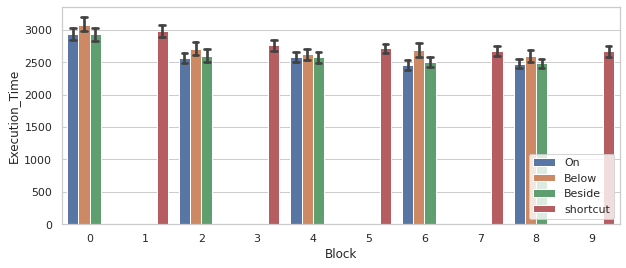

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="Block", y="Execution_Time",hue="IV_Surface", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="Block", y="Execution_Time", hue="IV_Surface", data=data_filtered, capsize=0.1, ci=95)
ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="Block", y="Execution_Time",hue="IV_Surface", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="Block", y="Execution_Time", hue="IV_Surface", data=data_filtered_word, capsize=0.1, ci=95)
ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)

NameError: ignored

<Figure size 720x288 with 0 Axes>

No handles with labels found to put in legend.


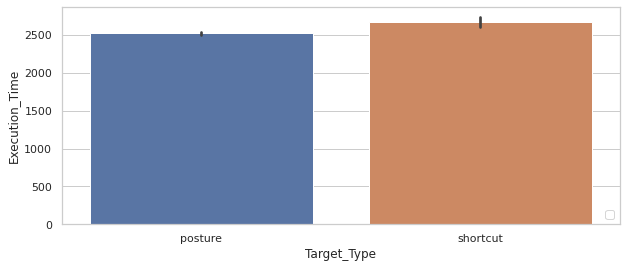

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="Block", y="Execution_Time",hue="IV_Surface", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="Target_Type", y="Execution_Time", data=data_filtered, ci=95,estimator=np.median)
ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)

No handles with labels found to put in legend.


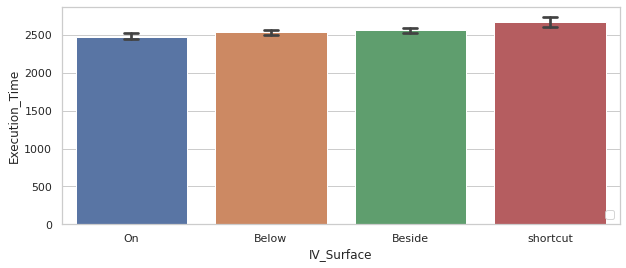

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="Block", y="Execution_Time",hue="IV_Surface", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="IV_Surface", y="Execution_Time", data=data_filtered, capsize=0.1, ci=95,estimator=np.median)
ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)

No handles with labels found to put in legend.


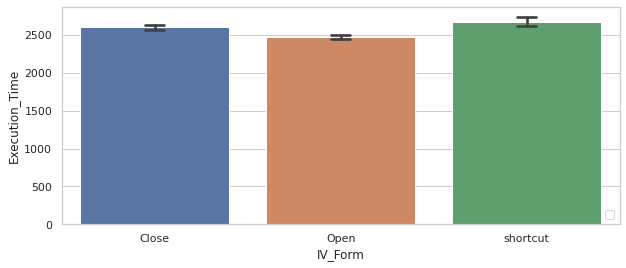

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="Block", y="Execution_Time",hue="IV_Surface", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="IV_Form", y="Execution_Time", data=data_filtered, capsize=0.1, ci=95,estimator=np.median)
ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)

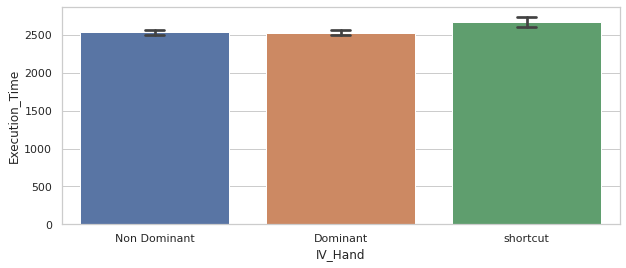

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="Block", y="Execution_Time",hue="IV_Surface", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="IV_Hand", y="Execution_Time", data=data_filtered, capsize=0.1, ci=95,estimator=np.median)
# ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)

Todo


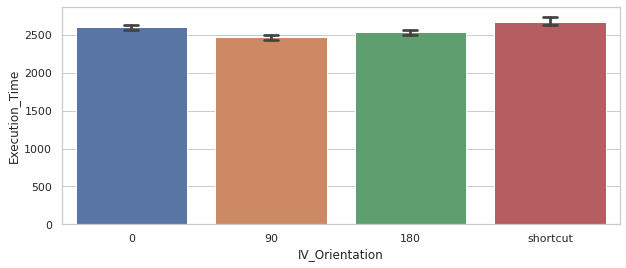

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="IV_Orientation", y="Execution_Time", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="IV_Orientation", y="Execution_Time", data=data_filtered, capsize=0.1, ci=95,estimator=np.median, order=["0","90","180","shortcut"])
# ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)

In [ ]:
df_all.head()
# df_all.count()
set(df_all["Participant"])

{'participant_31',
 'participant_32',
 'participant_33',
 'participant_34',
 'participant_35',
 'participant_36',
 'participant_37',
 'participant_38',
 'participant_39',
 'participant_40',
 'participant_41',
 'participant_42',
 'participant_43',
 'participant_44',
 'participant_45',
 'participant_46',
 'participant_47',
 'participant_48',
 'participant_49',
 'participant_50'}

In [ ]:
df_all.to_csv('df_all.csv') 
files.download('df_all.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
a = df_all.loc[df_all["Target_Type"]=="shortcut"]
a.count()
a.head()

,Participant,TempBlock,Block,Sequence,Trial,Target_Type,Target_Name,Start_Time,End_Time,First_Reaction_Time,Mode_In_Time,Mode_Out_Time,Execution_Time,Completion_Time,Reference_Action_Count,Incorrect_Action_Count,Error,IV_Surface,IV_Orientation,IV_Form,IV_Hand,Previous_Reference_Task,Next_Reference_Task
73,participant_31,0,1,0,73,shortcut,N,1567119167839,1567119173739,1567119173739,5932,136,6068,5900,0,0,False,shortcut,shortcut,shortcut,shortcut,click,word
75,participant_31,0,1,1,75,shortcut,Z,1567119179808,1567119182574,1567119182574,2766,1667,4433,2766,0,1,False,shortcut,shortcut,shortcut,shortcut,word,click
77,participant_31,0,1,2,77,shortcut,down,1567119184273,1567119186772,1567119186772,2531,133,2664,2499,0,0,False,shortcut,shortcut,shortcut,shortcut,click,word
79,participant_31,0,1,3,79,shortcut,E,1567119188973,1567119191241,1567119191241,2301,100,2401,2268,0,0,False,shortcut,shortcut,shortcut,shortcut,word,word
81,participant_31,0,1,4,81,shortcut,Y,1567119193205,1567119195141,1567119195141,1966,1563,3529,1936,0,0,False,shortcut,shortcut,shortcut,shortcut,word,click


### Completion Time

In [ ]:
df_2_to_5= data_filtered.loc[df_filtered["Block"] != 0]

# df_2_to_5_word = df_2_to_5.loc[df_2_to_5["Reference_Task"]=="word"]
# df_2_to_5_click = df_2_to_5.loc[df_2_to_5["Reference_Task"]=="click"]
data_block = remove_outliers(df_2_to_5, 'Completion_Time', aggregateby=['Block','Participant'], threshold=1)
data_block_word = data_block.loc[data_block["Reference_Task"]=="word"]
data_block_click = data_block.loc[data_block["Reference_Task"]=="click"]

KeyError: ignored

In [ ]:
# TAsk completion time for shortcuts coming from word
print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="posture") & (df_2_to_5["Reference_Task"]=="word")]["Completion_Time"].mean())
print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="shortcut") & (df_2_to_5["Reference_Task"]=="word")]["Completion_Time"].mean())

# data_filtered.loc[(data_filtered["Target_Type"]=="shortcut") & (data_filtered["Reference_Task"]=="word")].groupby("Block")["Completion_Time"].mean()
# # TAsk completion time for shortcuts coming from click
# print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="shortcut") & (df_2_to_5["Reference_Task"]=="click")]["Execution_Time"].mean())

KeyError: ignored

In [ ]:
# print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="posture") & (df_2_to_5["Reference_Task"]=="click")]["Completion_Time"].mean())
# print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="shortcut") & (df_2_to_5["Reference_Task"]=="click")]["Completion_Time"].mean())
print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="posture")]["Completion_Time"].mean())
print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="posture")]["Completion_Time"].std())
print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="shortcut")]["Completion_Time"].mean())
print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="shortcut")]["Completion_Time"].std())
# print(list(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="posture") & (df_2_to_5["Reference_Task"]=="click")]["Completion_Time"]))

# data_filtered.loc[(data_filtered["Target_Type"]=="shortcut") & (data_filtered["Reference_Task"]=="click")].groupby("Block")["Completion_Time"].mean()


1268.1060988812703
517.4792570903178
1937.9502587694078
712.8359638909789


In [ ]:
# print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="posture") & (df_2_to_5["Reference_Task"]=="click")]["Completion_Time"].mean())
# print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="shortcut") & (df_2_to_5["Reference_Task"]=="click")]["Completion_Time"].mean())
print(data_block.loc[(data_block["Target_Type"]=="posture")]["Completion_Time"].mean())
print(data_block.loc[(data_block["Target_Type"]=="posture")]["Completion_Time"].std())
print(data_block.loc[(data_block["Target_Type"]=="shortcut")]["Completion_Time"].mean())
print(data_block.loc[(data_block["Target_Type"]=="shortcut")]["Completion_Time"].std())
# print(list(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="posture") & (df_2_to_5["Reference_Task"]=="click")]["Completion_Time"]))

# data_filtered.loc[(data_filtered["Target_Type"]=="shortcut") & (data_filtered["Reference_Task"]=="click")].groupby("Block")["Completion_Time"].mean()


1139.050963081862
244.2308226085281
1738.7931954636424
458.31444452157336


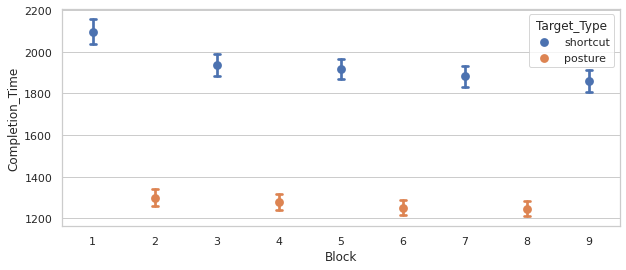

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# plt.xticks(rotation=90)
# ax = sns.barplot(x="Block", y="Execution_Time", hue="Target_Type", data=data_filtered, capsize=0.1, ci=95)
ax = sns.pointplot(x="Block", y="Completion_Time",hue="Target_Type", err_style="bars", data=df_2_to_5, capsize=0.1, ci=95, dashes=True)
# ax = sns.swarmplot(x="Block", y="Execution_Time",hue="Target_Type", data=data_filtered)
# ax = sns.lineplot(x="Block", y="Execution_Time", hue="Target_Type", units="subject", estimator=None, lw=1, data=fmri.query("region == 'frontal'"))

# ax.legend(loc='upper right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)
# plt.xlim(0, 4)
# plt.grid('off')
# Add rectangle
# ax.add_patch(
# patches.Rectangle(
# (50, 50), # (x,y)
# 50, # width
# 50, # height
# # You can add rotation as well with 'angle'
# alpha=0.3, facecolor="red", edgecolor="black", linewidth=3, linestyle='solid'
# )
# )

arr = {0:-0.6,1:0.2,2:1.4,3:2.2,4:3.4, 5:4.2,6:5.4,7:6.2,8:7.4,9:8.2}
# for index, row in data_filtered.groupby(["Block","Target_Type"]).mean().reset_index().iterrows():
# #     print(row["Execution_Time"])
# #     print(index)
#     ax.text(arr[index]/2,-101, round(row["Execution_Time"]/1000,2), color='black')

No handles with labels found to put in legend.


(1000.0, 2000.0)

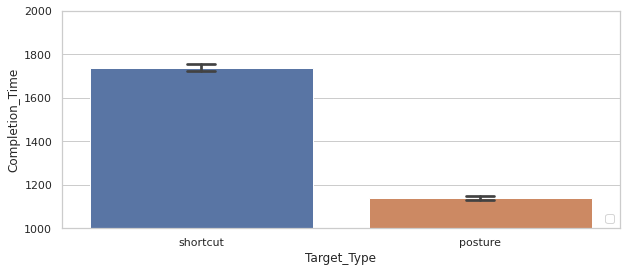

In [ ]:
sns.set(style="whitegrid")
# plt.ylim(1000, 2000)

plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="Block", y="Execution_Time",hue="IV_Surface", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="Target_Type", y="Completion_Time", data=data_block, capsize=0.1)
ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)
ax.axes.set_ylim(1000,2000)

No handles with labels found to put in legend.


(1000.0, 2000.0)

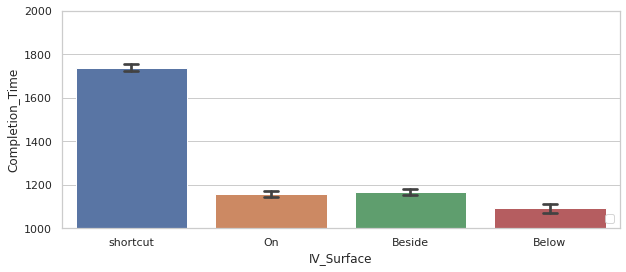

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="Block", y="Execution_Time",hue="IV_Surface", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="IV_Surface", y="Completion_Time", data=data_block, capsize=0.1)
ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)
ax.axes.set_ylim(1000,2000)

In [ ]:
# data_filtered_click.loc[data_filtered_click["Target_Type"]=="posture") & data_filtered_click[]]

No handles with labels found to put in legend.


(1000.0, 2000.0)

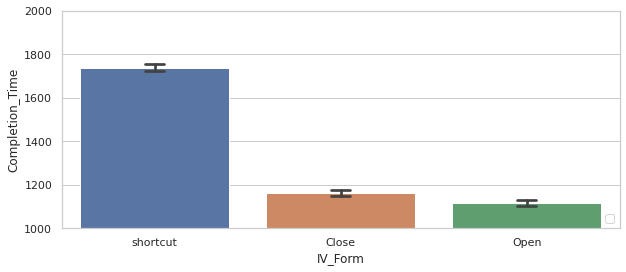

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="Block", y="Execution_Time",hue="IV_Form", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="IV_Form", y="Completion_Time", data=data_block, capsize=0.1)
ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)
ax.axes.set_ylim(1000,2000)

No handles with labels found to put in legend.


(1000.0, 2000.0)

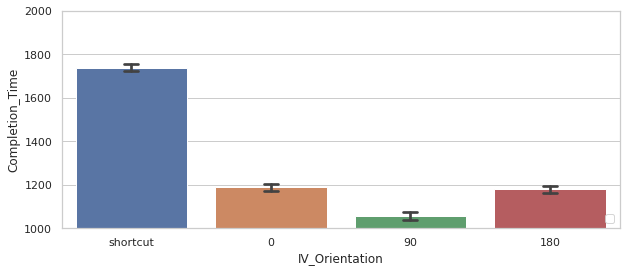

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="Block", y="Execution_Time",hue="IV_Form", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="IV_Orientation", y="Completion_Time", data=data_block, capsize=0.1)
ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)
ax.axes.set_ylim(1000,2000)

No handles with labels found to put in legend.


(1000.0, 2000.0)

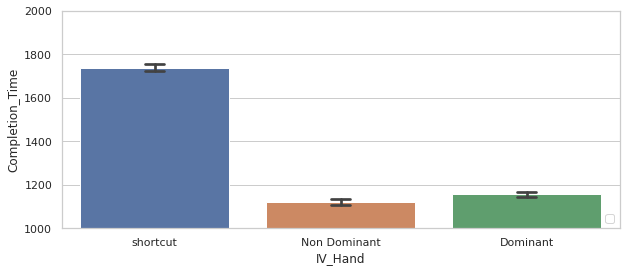

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))

# ax = sns.pointplot(x="Block", y="Execution_Time",hue="IV_Form", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="IV_Hand", y="Completion_Time", data=data_block, capsize=0.1, ci=95)
ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)
ax.axes.set_ylim(1000,2000)

### Transition Time

In [ ]:
# print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="posture") & (df_2_to_5["Reference_Task"]=="click")]["Completion_Time"].mean())
# print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="shortcut") & (df_2_to_5["Reference_Task"]=="click")]["Completion_Time"].mean())
print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="posture")]["Mode_Out_Time"].mean())
print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="posture")]["Mode_Out_Time"].std())
print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="shortcut")]["Mode_Out_Time"].mean())
print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="shortcut")]["Mode_Out_Time"].std())
# print(list(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="posture") & (df_2_to_5["Reference_Task"]=="click")]["Completion_Time"]))

# data_filtered.loc[(data_filtered["Target_Type"]=="shortcut") & (data_filtered["Reference_Task"]=="click")].groupby("Block")["Completion_Time"].mean()


NameError: ignored

In [ ]:
# print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="posture") & (df_2_to_5["Reference_Task"]=="click")]["Completion_Time"].mean())
# print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="shortcut") & (df_2_to_5["Reference_Task"]=="click")]["Completion_Time"].mean())
print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="posture")]["Mode_In_Time"].mean())
print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="posture")]["Mode_In_Time"].std())
print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="shortcut")]["Mode_In_Time"].mean())
print(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="shortcut")]["Mode_In_Time"].std())
# print(list(df_2_to_5.loc[(df_2_to_5["Target_Type"]=="posture") & (df_2_to_5["Reference_Task"]=="click")]["Completion_Time"]))

# data_filtered.loc[(data_filtered["Target_Type"]=="shortcut") & (data_filtered["Reference_Task"]=="click")].groupby("Block")["Completion_Time"].mean()


NameError: ignored

In [ ]:
# ax = sns.boxplot(x="Target_Type", y="Mode_In_Time", data=df_2_to_5)
ax = sns.boxplot(x="Target_Type", y="Mode_Out_Time", data=data_block)


In [ ]:
ax = sns.boxplot(x="Target_Type", y="Mode_In_Time", data=data_block)

In [ ]:
sns.set(style="whitegrid")
# plt.ylim(1000, 2000)

plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="Block", y="Execution_Time",hue="IV_Surface", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="Target_Type", y="Completion_Time", data=df_2_to_5, capsize=0.1)
ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)